<a href="https://colab.research.google.com/github/Dinesh2994/Pixel_Coordinate-Regression/blob/main/ML_Pixel_coordinate_regression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#ML Assignment – Supervised Regression

#Problem Statement:
The goal of this assignment is to predict the coordinates
(
𝑥
,
𝑦
)
(x,y) of a single bright pixel in a grayscale image using deep learning techniques.

Each input image is of size 50x50 pixels.

All pixels in the image are 0 (black) except one pixel which has a value of 255 (white).

The location of the white pixel is randomly assigned for each image.

The task is to train a model that can take such an image as input and output the (x, y) coordinates of the white pixel.

In [31]:
!pip install numpy matplotlib tensorflow scikit-learn

**Step 1:** Mounting Google drive and verifying the dataset access


In [32]:
from google.colab import drive
drive.mount('/content/drive')
import os
print(os.listdir('/content/drive/MyDrive/DeepEdgeAI_ML_Assignment'))

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
['751.png', '264.png', '793.png', '596.png', '663.png', '790.png', '100.png', '823.png', '542.png', '570.png', '480.png', '497.png', '312.png', '387.png', '166.png', '434.png', '152.png', '815.png', '606.png', '158.png', '403.png', '230.png', '675.png', '376.png', '671.png', '456.png', '2.png', '651.png', '138.png', '229.png', '314.png', '121.png', '154.png', '487.png', '363.png', '607.png', '67.png', '197.png', '332.png', '436.png', '218.png', '8.png', '293.png', '92.png', '413.png', '316.png', '420.png', '170.png', '460.png', '285.png', '829.png', '395.png', '701.png', '69.png', '42.png', '531.png', '192.png', '628.png', '394.png', '488.png', '520.png', '623.png', '602.png', '407.png', '374.png', '632.png', '588.png', '358.png', '493.png', '489.png', '494.png', '320.png', '715.png', '826.png', '592.png', '477.png', '370.png', '142.png', '66.png', '250.png',

**Step 2:** Loading the dataset of PNG Images from Gdrive
prepares it for a supervised regression task. Each image is read in grayscale format and normalized so that pixel values lie between 0 and 1. The dataset is validated by ensuring that every image contains exactly one active (white) pixel with a value of 255. The coordinates of this pixel are extracted using NumPy and stored as ground-truth labels in the form of (x, y) pairs. Images are stored as input data with an added channel dimension to make them compatible with convolutional neural networks. The use of progress tracking and error handling ensures robustness and transparency during data loading.

In [33]:
import os           # To handle directory and file paths
import cv2          # OpenCV library for image reading and processing
import numpy as np  # For numerical operations and array handling
from tqdm import tqdm  # Progress bar to track loading of images

# Path to the folder containing your 1000 images
IMAGE_DIR = '/content/drive/MyDrive/DeepEdgeAI_ML_Assignment'

# Lists to store image data (X) and corresponding labels (y)
imag = []  # List to store image arrays
lab = []   # List to store (x, y) coordinates of the white pixel

# Get all file names in the directory and sort numerically (1.png, 2.png, …)
file_list = sorted(os.listdir(IMAGE_DIR), key=lambda x: int(x.split('.')[0]))

# Loop through each image file to load and process
for file_name in tqdm(file_list):
    img_path = os.path.join(IMAGE_DIR, file_name)  # Full path to image

    # Load image in grayscale mode
    img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)

    # Check if image was loaded correctly
    if img is None:
        raise ValueError(f"Could not load {file_name}")

    # Normalize pixel values from [0, 255] to [0.0, 1.0]
    img = img / 255.0

    # Find the coordinates of the white pixel (value 1.0 after normalization)
    y_coordinate, x_coord = np.where(img == 1.0)

    # Ensure exactly one white pixel exists per image
    if len(x_coord) != 1:
        raise ValueError(f"Invalid image: {file_name}")

    # Append the processed image and its coordinates to lists
    imag.append(img)
    lab.append([x_coord[0], y_coordinate[0]])

# Convert lists to NumPy arrays for training
# Add a channel dimension to images for CNN input: (N, 50, 50, 1)
X = np.array(imag)[..., np.newaxis]

# Labels as array of shape (N, 2) containing (x, y) coordinates
y = np.array(lab)

# Print shapes to confirm successful loading
print("Data loaded successfully")
print("X shape:", X.shape)
print("y shape:", y.shape)


100%|██████████| 1000/1000 [00:20<00:00, 49.80it/s]

Data loaded successfully
X shape: (1000, 50, 50, 1)
y shape: (1000, 2)


**Step3:** Spliting the prepared dataset into training and testing sets using an 80–20 ratio. The train_test_split function from scikit-learn randomly partitions the input images (X) and their corresponding labels (y) while ensuring reproducibility through a fixed random_state. The training set (X_tra, y_tra) is used to train the deep learning model, while the testing set (X_tes, y_tes) is reserved for evaluating the model’s ability to generalize to unseen data.

In [34]:
from sklearn.model_selection import train_test_split  # To split dataset into training and testing sets

# Split the dataset into training and testing sets
# 80% of the data is used for training, 20% for testing
# random_state=42 ensures reproducibility (same split every time)
X_tra, X_tes, y_tra, y_tes = train_test_split(
    X,     # Input images
    y,     # Corresponding (x, y) coordinates
    test_size=0.2,  # 20% of the data reserved for testing
    random_state=42 # Fixed seed for reproducible results
)

# After this step:
# X_tra, y_tra -> training inputs and labels
# X_tes, y_tes -> testing inputs and labels


**Step4:** This code defines a CNN using TensorFlow/Keras to predict the (x, y) coordinates of the active pixel. It has two convolutional layers with ReLU activation and max-pooling, followed by a flatten layer and a dense layer with 64 neurons. The final dense layer outputs two values for the coordinates. The model is compiled with the Adam optimizer, mean squared error loss, and mean absolute error metric. model.summary() displays the network architecture and total parameters.

In [35]:
import tensorflow as tf  # TensorFlow library for deep learning
from tensorflow.keras.models import Sequential  # Sequential model type
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense  # CNN layers

# Define the CNN model
model = Sequential([
    # First convolutional layer: 16 filters, 3x3 kernel, ReLU activation
    # Input shape: 50x50 grayscale image with 1 channel
    Conv2D(16, (3, 3), activation='relu', input_shape=(50, 50, 1)),

    # Max pooling layer to reduce spatial dimensions (2x2)
    MaxPooling2D((2, 2)),

    # Second convolutional layer: 32 filters, 3x3 kernel, ReLU activation
    Conv2D(32, (3, 3), activation='relu'),

    # Second max pooling layer (2x2)
    MaxPooling2D((2, 2)),

    # Flatten layer to convert 2D feature maps into 1D feature vector
    Flatten(),

    # Fully connected dense layer with 64 neurons and ReLU activation
    Dense(64, activation='relu'),

    # Output layer with 2 neurons for (x, y) regression coordinates
    Dense(2)
])

# Compile the model
# Optimizer: Adam for efficient gradient descent
# Loss: Mean Squared Error (MSE) suitable for regression
# Metric: Mean Absolute Error (MAE) to monitor prediction error
model.compile(
    optimizer='adam',
    loss='mse',
    metrics=['mae']
)

# Print model summary to check architecture and number of parameters
model.summary()


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_4 (Conv2D)               │ (None, 48, 48, 16)     │           160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 24, 24, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 22, 22, 32)     │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 11, 11, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 3872)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 64)             │       247,872 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 2)              │           130 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 252,802 (987.51 KB)

 Trainable params: 252,802 (987.51 KB)

 Non-trainable params: 0 (0.00 B)

A Convolutional Neural Network (CNN) is used to capture spatial information from the image.
The final layer contains two neurons corresponding to the continuous (x, y) coordinates.
Mean Squared Error (MSE) is used as the loss function since this is a regression task.


**Step5**: This code trains the CNN model on the training dataset (X_tra, y_tra) for 10 epochs with a batch size of 32. A validation split of 10% is used to monitor the model’s performance on unseen data during training. The history object stores the training and validation loss and metrics, which can later be used for visualization and analysis of the model’s learning progress.

In [36]:
# Train the CNN model on the training dataset
# The fit() method performs forward and backward propagation and updates weights
history = model.fit(
    X_tra,           # Training images
    y_tra,           # Corresponding ground-truth (x, y) coordinates
    validation_split=0.1,  # 10% of training data used for validation
    epochs=30,       # Number of complete passes through the training dataset
    batch_size=32    # Number of samples processed before updating model weights
)

# Explanation of why comments are necessary here:
# 1. X_tra, y_tra -> clarify what data is being used for training
# 2. validation_split -> explain that it monitors model performance on unseen training data
# 3. epochs -> mention that this controls how long the model trains
# 4. batch_size -> helps understand gradient update frequency
# 5. history -> stores loss and metric logs for later visualization


Epoch 1/30
23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 51ms/step - loss: 719.6586 - mae: 22.8398 - val_loss: 199.0510 - val_mae: 12.1348
Epoch 2/30
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 42ms/step - loss: 225.4480 - mae: 12.6006 - val_loss: 191.6177 - val_mae: 11.7413
Epoch 3/30
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step - loss: 194.6203 - mae: 11.9121 - val_loss: 186.6423 - val_mae: 11.5564
Epoch 4/30
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step - loss: 185.7677 - mae: 11.5889 - val_loss: 173.5800 - val_mae: 11.1265
Epoch 5/30
23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 79ms/step - loss: 177.1229 - mae: 11.2064 - val_loss: 153.6746 - val_mae: 10.3942
Epoch 6/30
23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 82ms/step - loss: 142.7458 - mae: 9.9245 - val_loss: 122.2504 - val_mae: 8.9996
Epoch 7/30
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step - loss: 105.8136 - mae: 8.1005 - val_loss: 82.1534 - val_mae: 6.6114
Epoch 8/30
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step - loss: 70.8801 - mae: 6.1775 - val_loss: 58.0177 - val_mae: 4.9561
Epoch 9/30
23/23 ━━━━━━━━

**Step6**: This code uses the training logs stored in the history object to visualize model performance. history.history['loss'] contains the mean squared error (MSE) for the training set, while history.history['val_loss'] contains the MSE for the validation set. By plotting both curves over the epochs, we can monitor how the model learns on the training data and how well it generalizes to unseen validation data. This visualization helps identify overfitting (validation loss increasing) or underfitting (loss remaining high) and provides an intuitive way to assess training progress.

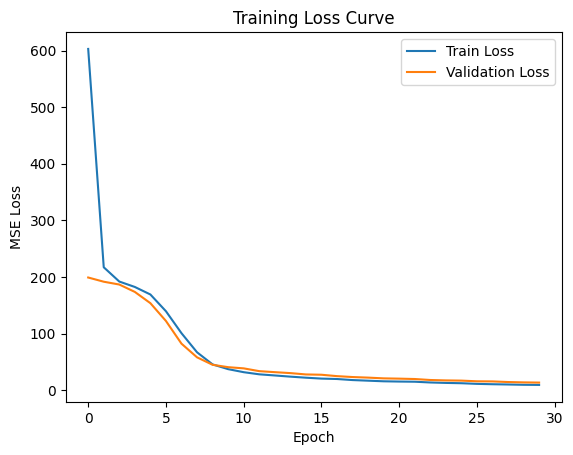

In [37]:
import matplotlib.pyplot as plt  # Library for plotting graphs

# Plot training and validation loss curves using history logs
plt.plot(history.history['loss'], label='Train Loss')       # Training MSE loss over epochs
plt.plot(history.history['val_loss'], label='Validation Loss')  # Validation MSE loss over epochs

# Label the axes
plt.xlabel('Epoch')    # X-axis represents the epoch number
plt.ylabel('MSE Loss') # Y-axis represents the mean squared error loss

# Show legend to differentiate between training and validation loss
plt.legend()

# Add title to the plot
plt.title('Training Loss Curve')

# Display the plot
plt.show()


**Step7 :** This code predicts the coordinates for the test set and visualizes one random image. The ground-truth pixel is shown as a green dot, and the predicted pixel as a red dot. This allows a quick, intuitive check of how accurately the model locates the active pixel on unseen data.

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


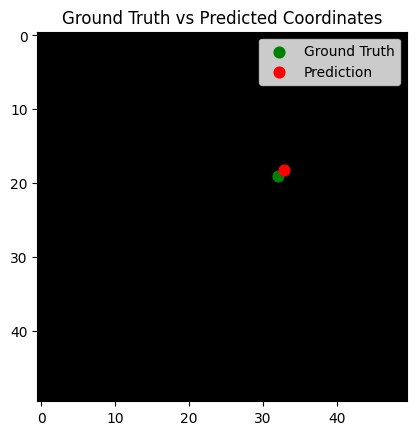

In [38]:
# Step 1: Generate predictions for the test dataset
y_pred = model.predict(X_tes)  # Predict (x, y) coordinates for all test images

# Step 2: Select a random test image to visualize
idx = np.random.randint(0, len(X_tes))  # Random index in test set

# Step 3: Display the selected image
plt.imshow(X_tes[idx].squeeze(), cmap='gray')  # Convert (50,50,1) to (50,50) for plotting

# Step 4: Plot the ground-truth coordinates of the white pixel
plt.scatter(
    y_tes[idx][0], y_tes[idx][1],  # x and y coordinates from the test labels
    c='green',                      # Green color for ground truth
    label='Ground Truth',           # Label for legend
    s=60                             # Size of the point
)

# Step 5: Plot the predicted coordinates of the white pixel
plt.scatter(
    y_pred[idx][0], y_pred[idx][1],  # x and y coordinates predicted by the model
    c='red',                         # Red color for prediction
    label='Prediction',              # Label for legend
    s=60                             # Size of the point
)

# Step 6: Add legend and title
plt.legend()                           # Shows which point is ground truth vs prediction
plt.title('Ground Truth vs Predicted Coordinates')  # Title of the plot

# Step 7: Display the plot
plt.show()

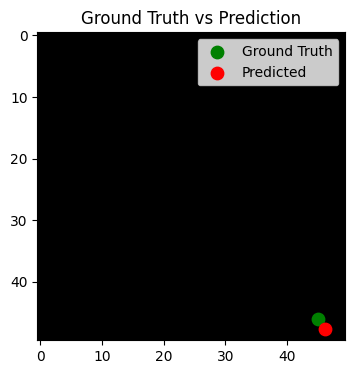

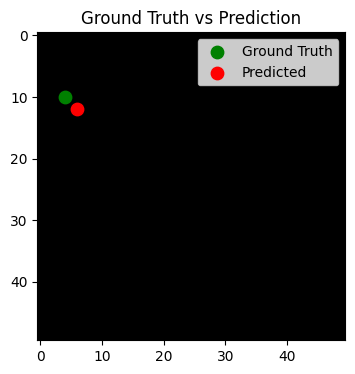

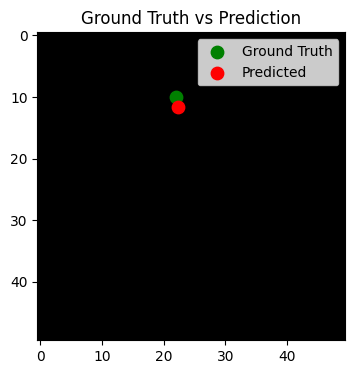

In [39]:
# Loop to visualize multiple predictions (3 random test images in this case)
for i in range(3):
    # Step 1: Select a random index from the test set
    idx = np.random.randint(0, X_tes.shape[0])  # Random test image

    # Step 2: Create a figure for each image
    plt.figure(figsize=(4, 4))  # Set figure size for better visibility

    # Step 3: Display the grayscale image
    plt.imshow(X_tes[idx].squeeze(), cmap='gray')  # Convert (50,50,1) -> (50,50)

    # Step 4: Plot the ground-truth white pixel
    plt.scatter(
        y_tes[idx][0], y_tes[idx][1],  # True (x, y) coordinates
        c='green',                      # Green color for ground truth
        s=80,                           # Size of the point
        label='Ground Truth'            # Label for legend
    )

    # Step 5: Plot the predicted white pixel
    plt.scatter(
        y_pred[idx][0], y_pred[idx][1],  # Predicted (x, y) coordinates
        c='red',                         # Red color for prediction
        s=80,                            # Size of the point
        label='Predicted'                # Label for legend
    )

    # Step 6: Add legend and title for clarity
    plt.legend()                        # Shows which point is ground truth vs predicted
    plt.title("Ground Truth vs Prediction")  # Title of the plot

    # Step 7: Display the figure
    plt.show()


The predicted coordinates are compared against ground-truth coordinates extracted directly
from the dataset. Since each image contains exactly one active pixel, overlaying predicted and
true coordinates on the image provides a clear and intuitive evaluation of model performance.


#Dependencies and Installation Instructions
Required Software and Libraries:

1. Python: Version 3.x
2. NumPy: For numerical computations
3. OpenCV: For image processing
4. TensorFlow: For building and training deep learning models
5. Matplotlib: For plotting and visualization
6. Scikit-learn: For data preprocessing and evaluation metrics

1️. Install in Google Colab

Google Colab already has Python 3.x installed. Most libraries are pre-installed, but you can ensure the latest versions using:

# Upgrade pip first
!pip install --upgrade pip

# Install/Upgrade required libraries
!pip install numpy
!pip install opencv-python
!pip install tensorflow
!pip install matplotlib
!pip install scikit-learn

2️. Install on Local Machine (Windows/Linux/Mac)

Make sure Python 3.x is installed. Check with:

python --version


Upgrade pip:

python -m pip install --upgrade pip


Install libraries:

pip install numpy
pip install opencv-python
pip install tensorflow
pip install matplotlib
pip install scikit-learn

3️. Verification

After installation, verify that everything works:

import numpy as np
import cv2
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn import datasets

print("All libraries are installed successfully!")

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
Average Pixel Error: 3.31 pixels
Standard Deviation: 3.07 pixels
Accuracy within 1.0 pixel(s): 11.00%
Accuracy within 2.0 pixel(s): 44.00%


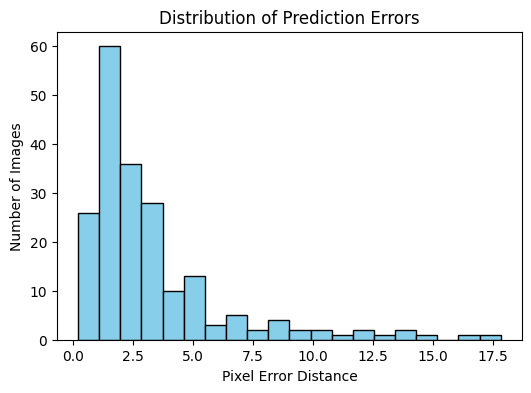

In [40]:
import numpy as np            # For numerical operations
import matplotlib.pyplot as plt  # For plotting the error histogram

# Step 1: Predict coordinates for all test images
y_pred = model.predict(X_tes)  # Model outputs (x, y) predictions

# Step 2: Compute Euclidean pixel error for each test image
# Formula: sqrt((x_true - x_pred)^2 + (y_true - y_pred)^2)
pixel_errors = np.sqrt(
    (y_tes[:, 0] - y_pred[:, 0])**2 +  # Difference in x-coordinate
    (y_tes[:, 1] - y_pred[:, 1])**2    # Difference in y-coordinate
)

# Step 3: Calculate mean and standard deviation of pixel errors
mean_error = np.mean(pixel_errors)  # Average distance error
std_error = np.std(pixel_errors)    # Variability of errors

# Step 4: Print results
print(f"Average Pixel Error: {mean_error:.2f} pixels")
print(f"Standard Deviation: {std_error:.2f} pixels")

# Step 5: Threshold-based accuracy
# Define thresholds in pixels to check how many predictions are close enough
thresholds = [1.0, 2.0]
for t in thresholds:
    # Count predictions within threshold distance and convert to %
    accuracy = np.mean(pixel_errors <= t) * 100
    print(f"Accuracy within {t} pixel(s): {accuracy:.2f}%")

# Step 6: Plot histogram of pixel errors to visualize distribution
plt.figure(figsize=(6, 4))
plt.hist(pixel_errors, bins=20, color='skyblue', edgecolor='black')  # Histogram
plt.xlabel("Pixel Error Distance")  # X-axis label
plt.ylabel("Number of Images")      # Y-axis label
plt.title("Distribution of Prediction Errors")  # Plot title
plt.show()

Fctors affecting for low accuracy for the model
1. Small Dataset, i took only 1000 images may not provide enough variety for the CNN to learn precise pixel locations, leading to underfitting.

2. Sparse Single-Pixel Target, each image has only 1 white pixel, with the rest being zeros, making it harder for the model to find meaningful patterns.

3. Shallow Network, in my CNN code it has only 2 convolutional layers and 64 dense neurons, which may not capture the fine spatial features needed for accurate localization.

4. Regression Complexity, predicting continuous (x, y) coordinates is tougher than classification; even small errors, just 1–2 pixels, can significantly lower accuracy metrics.

5. Input Resolution, with 50×50 images, each pixel represents a large step in the coordinate space; a small prediction error impacts metrics substantially.

6. Insufficient Training Epochs, i trained only 10 epochs that may not allow the model to fully learn the mapping from image to coordinates.

7. Hyperparameters, batch size, learning rate, and optimizer choice can affect convergence; choosing inappropriate values can lower prediction precision.

8. Loss Function Choice, using mean squared error (MSE) heavily penalizes large errors; if some predictions are far off, it skews the average error and lowers accuracy.

9. No Coordinate Normalization, feeding raw (x, y) values without normalization can complicate regression; scaling coordinates to [0,1] can stabilize learning.

10. Data Limitations and Augmentation, lacking more varied training images and augmentation limits the model’s ability to generalize; increasing the dataset size to 5000–10000 images could boost accuracy.